# Exact, Partition Function-aware Jacobians 
## for H$_2$O transmission spectrum
### still single layer Earth atmosphere, just now with $\log{Z}$
### Using HITRAN, `jax`, and NVIDIA GPUs

Beginning to be more realistic

In [1]:
%%capture
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import hapi
hapi.db_begin('../../hapi/data/')

In [2]:
! du -hs ../../hapi/data/

272M	../../hapi/data/


### Convert from $\text{cm}^{-1}$ to Angstroms.

In [3]:
wls = (np.arange(15000, 25000, 0.5) * u.Angstrom)[::-1]
nus = wls.to(1/u.cm, equivalencies=u.spectral()).value
wls = wls.value
nu_lo, nu_hi = nus.min().astype(np.int), nus.max().astype(np.int)

You can calculate the partition function with HAPI.

In [4]:
hapi.partitionSum(1,1, [296])

[174.58122640000002]

In [5]:
h2o_vol_mix_ratio_air = 1.0e-3

In [6]:
%%time
nu, coeff_air = hapi.absorptionCoefficient_Lorentz(SourceTables='H2O', Diluent={'air':1.0-h2o_vol_mix_ratio_air, 'H2O':h2o_vol_mix_ratio_air}, WavenumberGrid=nus.tolist(), HITRAN_units=True)#range(4000,10000,1))

{'air': 0.999, 'H2O': 0.001}
CPU times: user 32.4 s, sys: 14.7 ms, total: 32.4 s
Wall time: 32.4 s


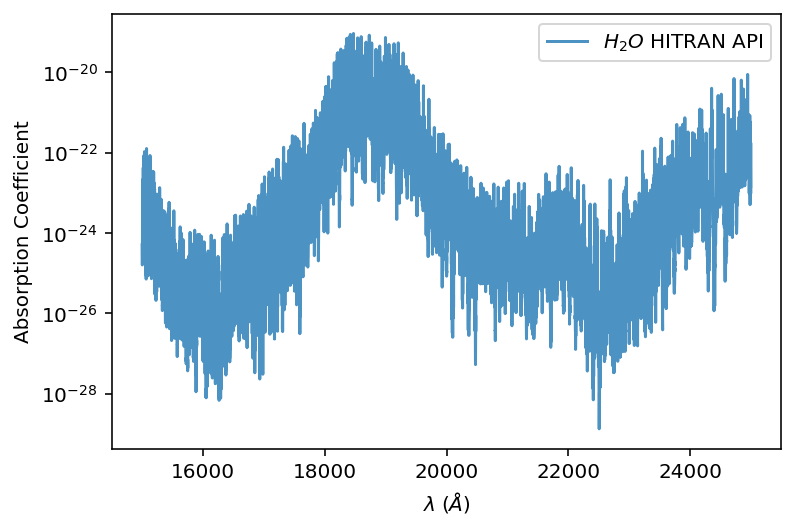

In [7]:
plt.plot(wls, coeff_air, label='$H_2O$ HITRAN API', alpha=0.8)
plt.legend(loc='upper right')
plt.ylabel('Absorption Coefficient')
plt.yscale('log')
plt.xlabel('$\lambda \;(\AA)$');

The net absorption coefficient depends on the pressure of the environment.  We'll have to include those effects later.

### Direct computation of the absorption coefficient with GPUs

We will include the linewings across the entire passband!

In [8]:
from jax.config import config
config.update("jax_enable_x64", True)

In [9]:
import jax.numpy as np
from jax import vmap, jit, grad, random
from jax.lax import stop_gradient

Compute Lorentz Profiles:  
$$ f_{L}(\nu; \nu_{ij}, T, p) = \frac{1}{\pi}\frac{\gamma(p, T)}{\gamma(p,T)^2, + [\nu-(\nu_{ij}+\delta(p_{ref})p)]^2}$$

We'll make an array that is $N_{lines} \times N_{wl}$ in size

In [10]:
@jit
def gamma_of_p_and_T(p, T, p_self, n_air, gamma_air_ref, gamma_self_ref):
    '''Compute the Lorentz HWHM with pressure and temp'''
    return (296.0/T)**n_air *(gamma_air_ref*(p-p_self) + gamma_self_ref*(p_self))

Let's try to map this function across all entries in the water line list.

In [11]:
n_air = hapi.getColumn('H2O', 'n_air')
gamma_air = hapi.getColumn('H2O', 'gamma_air')
gamma_self = hapi.getColumn('H2O', 'gamma_self')

In [12]:
%%time
gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(1.0, 296.0,0.001, n_air, gamma_air, gamma_self)

CPU times: user 146 ms, sys: 401 ms, total: 547 ms
Wall time: 655 ms


Yay!  We have our gammas to input into the Lorentz profile function

In [13]:
@jit
def lorentz_profile(nu, p, nu_ij, gamma, dp_ref, S_ij):
    '''Return the Lorentz line profile given vectors and parameters'''
    return S_ij/np.pi * gamma / ( gamma**2 + (nu - (nu_ij + dp_ref*p))**2)

### Total Internal Partition Sum (TIPS)  
Defined [here](https://hitran.org/docs/definitions-and-units/)

In [14]:
#hapi.describe('H2O')

In [15]:
@jit
def tips_Q_of_T(T, g_k, E_k):
    '''Total Internal Partition Sum'''
    c_2 = 1.4387770 #cm K
    return np.sum( g_k * np.exp(- c_2 * E_k / T) )

In [16]:
E_lower = hapi.getColumn('H2O', 'elower')
g_lower = hapi.getColumn('H2O', 'gpp')
g_upper = hapi.getColumn('H2O', 'gp')
nu_lines = hapi.getColumn('H2O', 'nu')
delta_air = hapi.getColumn('H2O', 'delta_air')
S_ij_296 = hapi.getColumn('H2O', 'sw')

In [17]:
Q_296 = tips_Q_of_T(296.0, g_lower, E_lower)

In [18]:
Q_296, np.array([hapi.partitionSum(1,i, [296.0])[0] for i in [1,2,3,4,5,6,7, 8, 9]]).sum()

(DeviceArray(16979.0710649, dtype=float64),
 DeviceArray(16657.0810168, dtype=float64))

Hmm!  We get different answers for the partition sum, but same order of magnitude.  Maybe something is off based on the isotopic abundances?

In [19]:
@jit
def S_ij_of_T(T, S_ij_296, nu_ij, g_lower, E_lower):
    '''The Spectral Line Intensity'''
    c_2 = 1.4387770 #cm K
    return (S_ij_296 * 
            stop_gradient(tips_Q_of_T(296.0, g_lower, E_lower)) / 
            tips_Q_of_T(T, g_lower, E_lower) *
            np.exp(-c_2 * E_lower/T) /np.exp(-c_2 * E_lower/296.0) *
           (1-np.exp(-c_2*nu_ij/T) )/(1-np.exp(-c_2*nu_ij/296.0)))

In [20]:
S_ij_of_T(297.0, S_ij_296, nu_lines, g_lower, E_lower)

DeviceArray([2.38042778e-25, 3.70964591e-24, 3.49283572e-23, ...,
             1.42496719e-26, 5.45962600e-26, 1.45299472e-28],            dtype=float64)

In [21]:
nus, wls = np.array(nus), np.array(wls)
nus.shape, gammas.shape

((20000,), (44902,))

In [22]:
from functools import partial

In [23]:
%%time
S_ij_in = S_ij_of_T(296.0, S_ij_296, nu_lines, g_lower, E_lower)
line_profile = jit(vmap(partial(lorentz_profile, p=1.0, nu_ij=nu_lines, gamma=gammas, dp_ref=delta_air, S_ij=S_ij_in)))(nus)
line_profile.shape

CPU times: user 415 ms, sys: 20.1 ms, total: 435 ms
Wall time: 550 ms


(20000, 44902)

Nice!  The *net* absorption coefficient is the sum on all lines:

In [24]:
%%time
net_abs_coeff = line_profile.sum(axis=1)

CPU times: user 223 ms, sys: 12 ms, total: 235 ms
Wall time: 364 ms


In [25]:
wls.shape

(20000,)

In [26]:
net_abs_coeff.shape

(20000,)

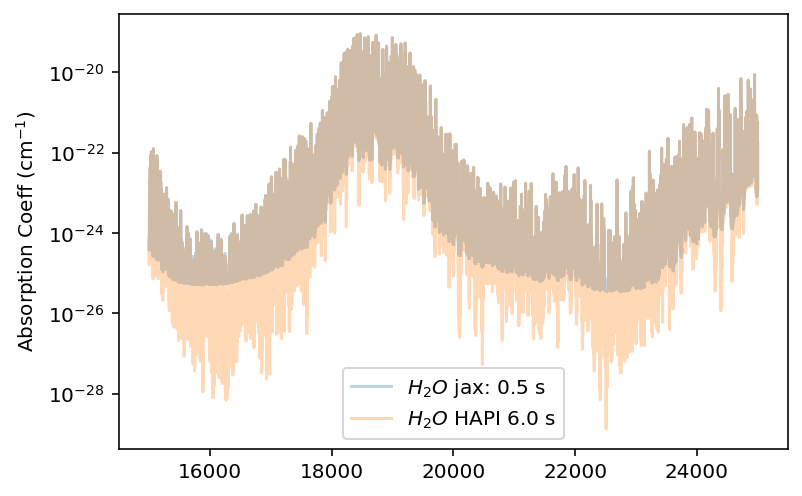

In [27]:
plt.plot(wls, net_abs_coeff, alpha=0.3, label='$H_2O$ jax: 0.5 s')


plt.plot(wls, coeff_air, label='$H_2O$ HAPI 6.0 s', alpha=0.3)
plt.yscale('log')
plt.ylabel('Absorption Coeff (cm$^{-1}$)')
plt.legend(loc='best');

Yay!  We did it!  We're **more accurate** than HAPI since we include the line wing contributions across the entire spectrum, now with the full partition function!! Woohoo!  So we're faster and more accurate than HAPI.

In [28]:
from jax import jacfwd

In [29]:
abs_of_p = jit(lambda p: vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0))(nus, p,
                                     nu_lines, gammas, delta_air, S_ij_in).sum(axis=0))

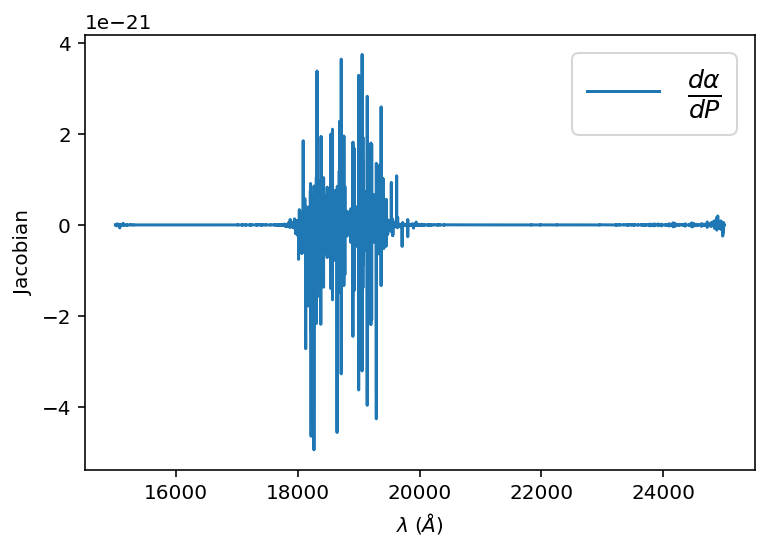

In [30]:
plt.plot(wls, jit(jacfwd(abs_of_p))(1.0), label=r'$\frac{d \alpha}{dP}$')
plt.legend(fontsize=18, loc='best')
plt.ylabel('Jacobian')
plt.xlabel('$\lambda \;(\AA)$');

Awesome!  Let's put it all together for Temperature.

### Temperature Jacobian

In [31]:
@jit
def abs_coeff_of_T(T):
    '''Return the absorption coefficient as a function of T'''
    
    gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(1.0, T,0.001, n_air, gamma_air, gamma_self)
    
    return vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0))(nus, 1.0,
                                     nu_lines, gammas, delta_air, S_ij_in).sum(axis=0)

In [32]:
%%time
abs_temp_jacobian = jacfwd(abs_coeff_of_T)(296.0)

CPU times: user 706 ms, sys: 12.1 ms, total: 718 ms
Wall time: 818 ms


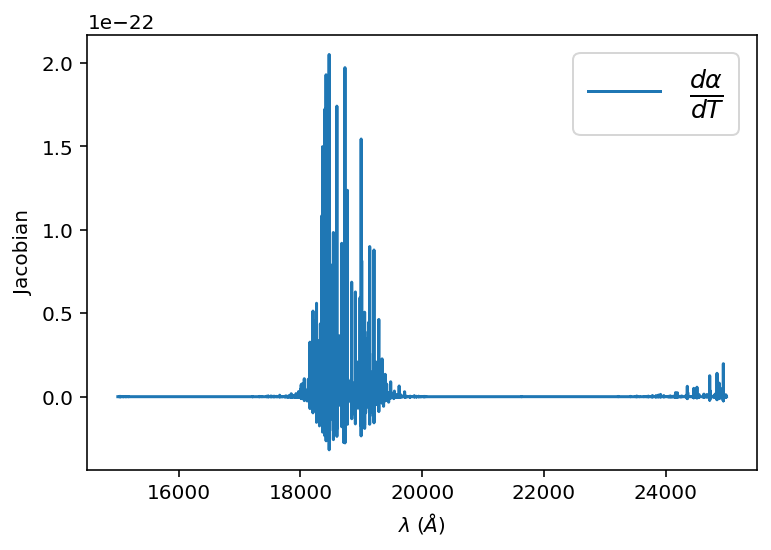

In [33]:
plt.plot(wls, abs_temp_jacobian, label=r'$\frac{d \alpha}{dT}$')
plt.legend(fontsize=18, loc='upper right')
plt.ylabel('Jacobian')
plt.xlabel('$\lambda \;(\AA)$');

### Let's compute the transmission spectrum!

Requires a path length.  Let's assume constant density of the Earth's atmosphere, and 3 km path length.

The HITRAN absorption coefficient $\alpha$ units are: $cm^{−1}/(molecule⋅cm^{−2})$

So we have the optical depth:

$$ \tau_{ij}(\nu, T, p) = \alpha \cdot n \cdot \ell$$

where $n$ is the number density of particles, and $\ell$ is the path length.

In [34]:
path_length = (3.0*u.km).to(u.cm).value

In [35]:
water_number_density =  (0.001*6.022e23/(22.4*u.liter)).to(u.cm**-3) # molecules cm^-3

In [36]:
@jit
def transmission_of_T_p(T, p):
    '''Return the absorption coefficient as a function of T'''
    
    gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(p, T,0.001, n_air, gamma_air, gamma_self)
    
    S_ij = S_ij_of_T(T, S_ij_296, nu_lines, g_lower, E_lower)
    
    abs_coeff = vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0))(nus, p,
                                     nu_lines, gammas, delta_air, S_ij).sum(axis=0)
    
    tau = abs_coeff * water_number_density.value * path_length
    return np.exp(-tau)

In [37]:
%%time
transmission_of_T_p(296.0, 1.0)

CPU times: user 779 ms, sys: 19.9 ms, total: 799 ms
Wall time: 1 s


DeviceArray([0.90568118, 0.82907033, 0.80476519, ..., 0.99625536,
             0.99557832, 0.9942204 ], dtype=float64)

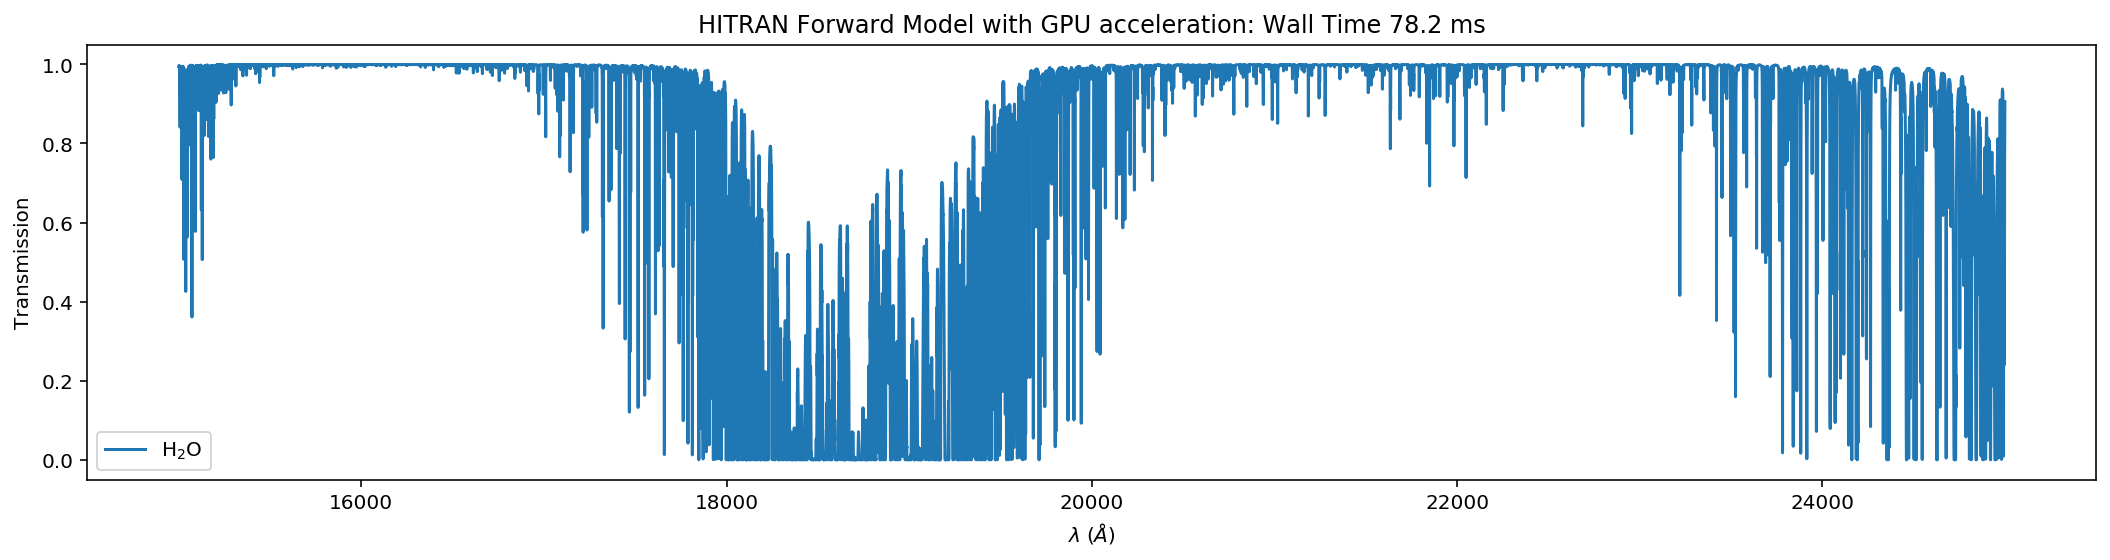

In [38]:
plt.figure(figsize=(18,4))
plt.plot(wls, transmission_of_T_p(296.0, 1.0), label='H$_2$O')
plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlabel('$\lambda \;(\AA)$')
plt.title('HITRAN Forward Model with GPU acceleration: Wall Time 78.2 ms');

Hooray!  That's the telluric absorption due to Earth's atmospheric water, under extreme assumptions that the atmosphere is composed of a single 3 km thick isothermal layer at STP.  But those assumptions can be relaxed later to yield more accurate estimates.

In [39]:
%%time
_ = jacfwd(transmission_of_T_p, argnums=0)(296.0, 1.0)

CPU times: user 1.5 s, sys: 8.32 ms, total: 1.51 s
Wall time: 1.8 s


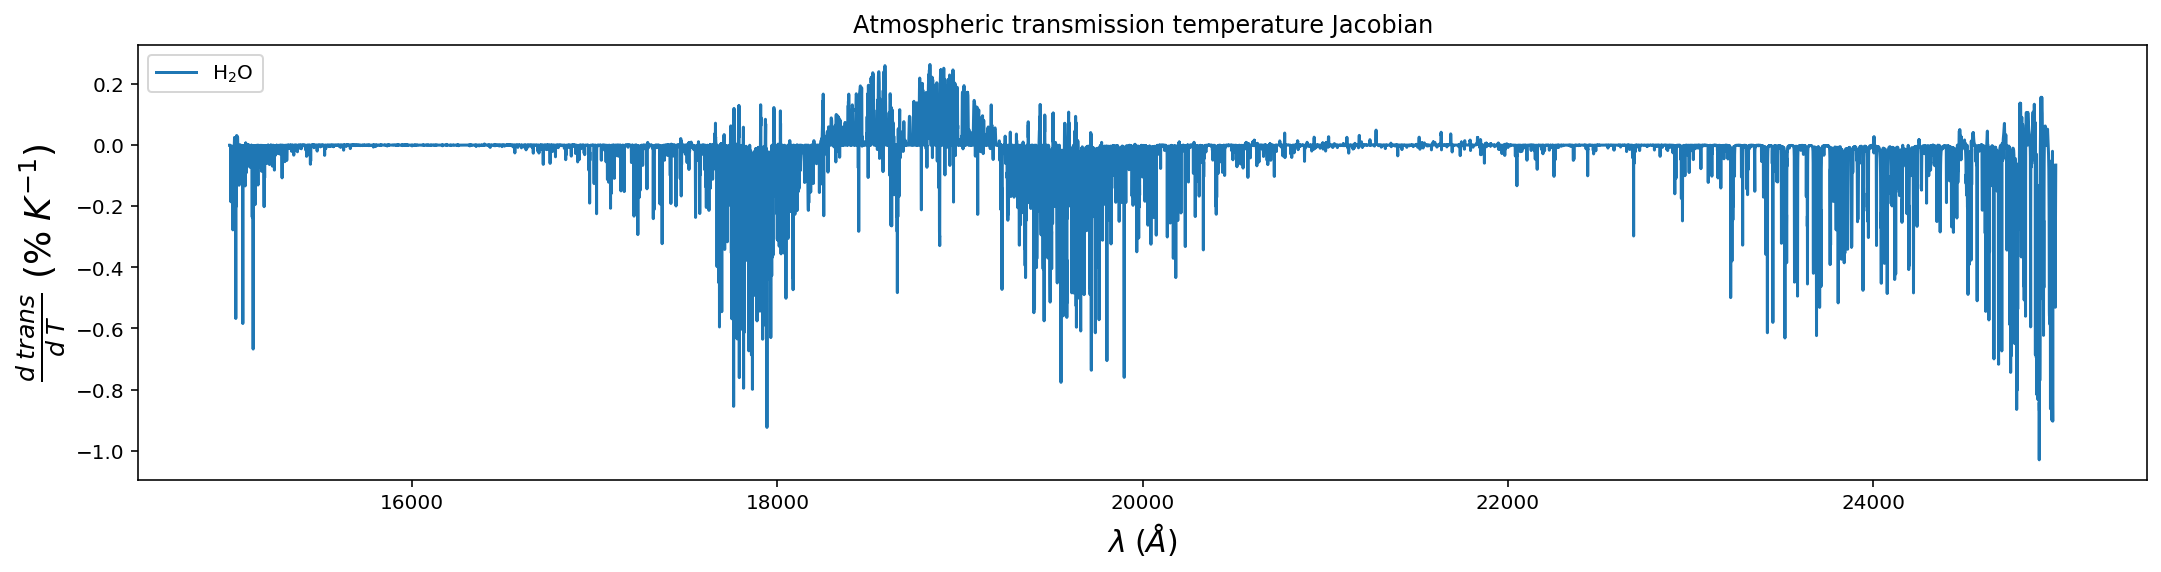

In [40]:
plt.figure(figsize=(18,4))
plt.plot(wls, jacfwd(transmission_of_T_p, argnums=0)(296.0, 1.0)*100.0, label='H$_2$O ')

plt.legend(loc='upper left')
plt.ylabel(r'$\frac{d\;trans}{d\;T}$ ($\% \;K^{-1}$)', fontdict={'fontsize':18})
plt.xlabel('$\lambda \;(\AA)$',fontdict={'fontsize':15})
plt.title('Atmospheric transmission temperature Jacobian');

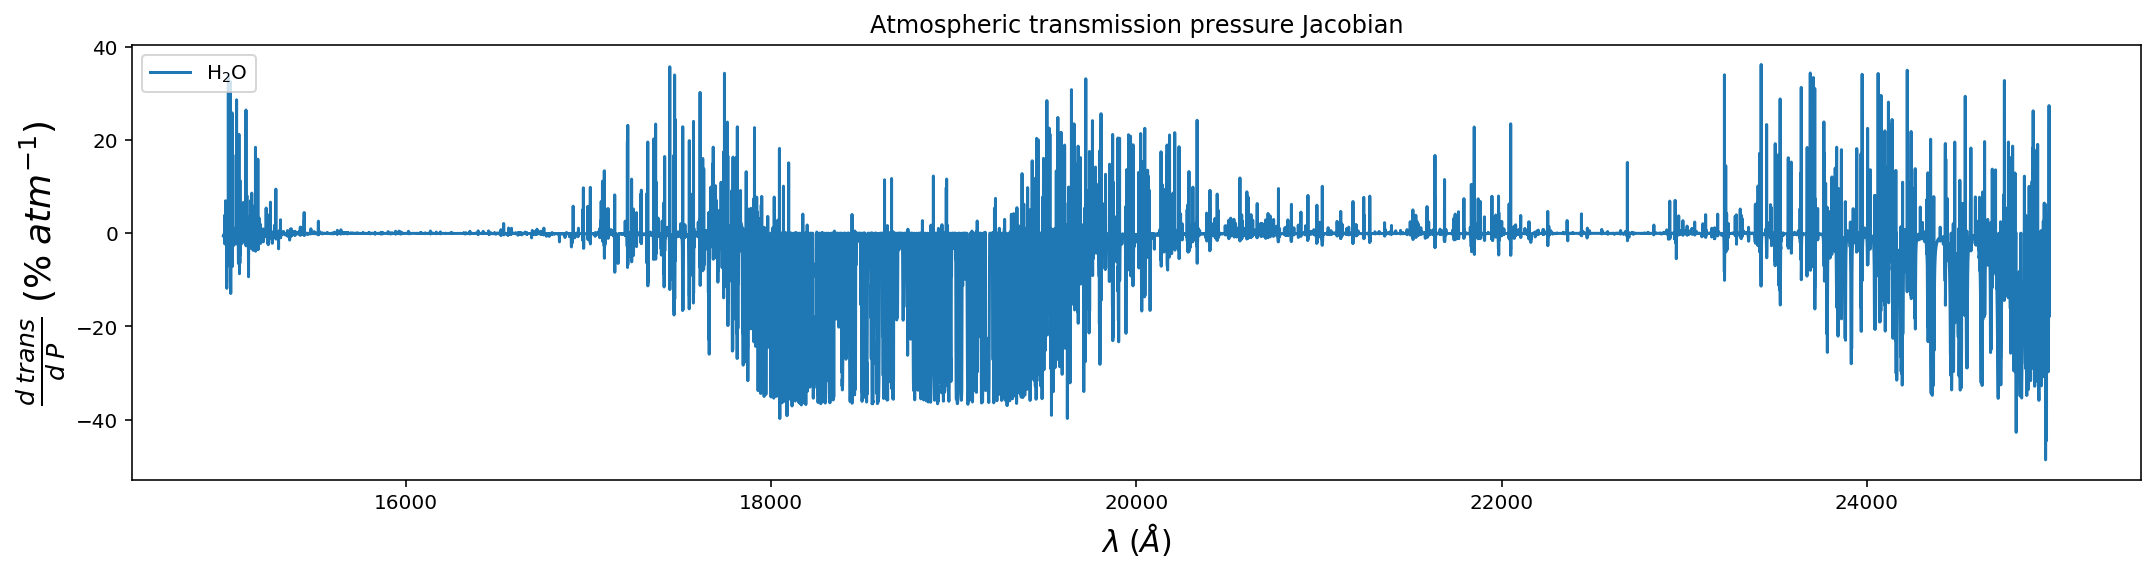

In [41]:
plt.figure(figsize=(18,4))
plt.plot(wls, jacfwd(transmission_of_T_p, argnums=1)(296.0, 1.0)*100.0, label='H$_2$O ')
plt.legend(loc='upper left')
plt.ylabel(r'$\frac{d\;trans}{d\;P}$ ($\% \;atm^{-1}$)', fontdict={'fontsize':18})
plt.xlabel('$\lambda \;(\AA)$',fontdict={'fontsize':15})
plt.title('Atmospheric transmission pressure Jacobian');

Awesome!  We made completed a task!

#### 1. ~~Include the temperature dependence of the cross section (and partition function)~~
All Done! We have implemented the partition function!

#### 2. ~~Make sure I'm using `jit` and `vmap` correctly.~~
I think I am using `jit`, and the `vmap` correctly now.  My NVIDIA GPU is using streaming multiprocessors (SM).  It does not need to fill up memory because it is streaming directly to the CUDA cores.

  What are the next steps?

#### 1. Add more vertical layers, with variable P-T profile.
We want to simulate a realistic atmosphere that has multiple vertical layers, with a varying P-T profile.


#### 2. Attempt to fit with fake data.
Can we use Jacobian-aware minimization techniques to fit the spectral lines at high resolution?